## Summary: Systematic effects on Edelweiss C

One wonders if a different estimate on the widening necessary for the nuclear-recoil band would happen if there were systematic errors on e.g. the recorded voltage on the detector.

This notebook examines the effect of possible systematics on C.

In [1]:
import numpy as np
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py

from scipy import optimize
import lmfit as lmf
import emcee

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

In [2]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

## Fit with an MCMC method

In [3]:
def log_likelihood(theta, ER_data, NR_data):
    aH, C, m, scale = theta
    x_ER, y_ER, yerr_ER = ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err']
    x, y, yerr = NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err']
    
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    model_ER = sigER_func(x_ER)
    sigma2_ER = yerr_ER**2
    model_NR = sigNR_func(x)
    sigma2_NR = yerr**2

    #print ((y-model_NR)**2/sigma2_NR)
    #print ((y_ER-model_ER)**2/sigma2_ER)
    return -0.5*(np.sum((y-model_NR)**2/sigma2_NR + np.log(2*np.pi*sigma2_NR)) \
                 + np.sum((y_ER-model_ER)**2/sigma2_ER + np.log(2*np.pi*sigma2_ER)))

In [4]:
def gauss_log_prior(theta):
    aH, C, m, scale = theta
    scale_sig_sq = 0.5*0.5
    scale_expected = 1
    
    if 0 < aH < 0.1 and 0.02 < C < 0.05 and -1e-3 < m < 1e-3 and 0 < scale < 100:
        return 0.0 - (scale-scale_expected)**2/(2*scale_sig_sq)
    return -np.inf

In [5]:
def new_log_probability(theta, ER_data, NR_data, prior_func):
    lp = prior_func(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ER_data, NR_data)

def lmf_negative_ll(params, Erecoil_ER, sigma_ER, sigma_err_ER, Erecoil_NR, sigma_NR, sigma_err_NR, prior_func):
    #aH, C, m, scale = params
    ER_data = {
        'Erecoil': Erecoil_ER,
        'sigma': sigma_ER,
        'sigma_err': sigma_err_ER}
    
    NR_data = {
        'Erecoil': Erecoil_NR,
        'sigma': sigma_NR,
        'sigma_err': sigma_err_NR}
    
    return -new_log_probability(params, ER_data, NR_data, prior_func)

In [6]:
# start at about the minimum
aH, C, m, scale = 0.0164, 0.0348, 9.39E-5, 1.0

## Find the minimum likelihood

In [7]:
# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resER_data = resER_data.sort_values(by='E_recoil')
resNR_data = resNR_data.sort_values(by='E_recoil')

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}

In [8]:
from scipy.optimize import minimize
np.random.seed(42)

params = lmf.Parameters()
#params.add('ion_center_0keV', value=ion_center_0keV, vary=False)
#params.add('ion_guard_0keV', value=ion_guard_0keV, vary=False)
#params.add('ion_122keV', value=ion_122keV, vary=False)
#params.add('heat_0keV', value=heat_0keV, vary=False)
#params.add('heat_122keV', value=heat_122keV, vary=False)
params.add('aH', value=0.01638)
params.add('C', value=0.0348)
params.add('m', value=9.39E-5)
params.add('scale', value=1.0)

nll = lambda *args: -log_likelihood(*args)

initial = np.array([aH, C, m, scale]) #+ 0.001*np.random.randn(2)
soln = minimize(nll, initial, method='Nelder-Mead', \
                args=(ER_data, NR_data))

aH_fit, C_fit, m_fit, scale_fit = soln.x
print (soln)

 final_simplex: (array([[1.66103826e-02, 3.50650957e-02, 9.05234028e-05, 9.83189289e-01],
       [1.66093091e-02, 3.50628900e-02, 9.05598780e-05, 9.83282609e-01],
       [1.66101352e-02, 3.50626988e-02, 9.05643577e-05, 9.83221947e-01],
       [1.66110610e-02, 3.50642556e-02, 9.05587165e-05, 9.83168006e-01],
       [1.66104578e-02, 3.50646999e-02, 9.05247633e-05, 9.83209395e-01]]), array([-52.87538084, -52.87538078, -52.87538076, -52.87538062,
       -52.87538049]))
           fun: -52.87538083814723
       message: 'Optimization terminated successfully.'
          nfev: 110
           nit: 60
        status: 0
       success: True
             x: array([1.66103826e-02, 3.50650957e-02, 9.05234028e-05, 9.83189289e-01])


In [9]:
# Does the minimum fit have a better chisq than the Edelweiss procedure?
print("Negative log-likelihood fit: ", log_likelihood((soln.x), ER_data, NR_data))
print("Edelweiss log-likelhood value: ", log_likelihood((0.01638, 0.03478, 9.3917e-05, 1), ER_data, NR_data))

Negative log-likelihood fit:  52.87538083814723
Edelweiss log-likelhood value:  52.87049364509039


In [10]:
Test = False
filename = 'data/edelweiss_C_systematicErrors_sampler_nll_4pars_wideGausPrior.h5'

# random walks starting near the minimum
ndim, nwalkers = 4, 100

In [11]:
if not Test:
    pos = [[aH_fit, C_fit, m_fit, scale_fit] + 1e-8*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, new_log_probability, args=(ER_data, NR_data, gauss_log_prior))
    sampler.run_mcmc(pos, 500)
    samples = sampler.chain
    
else:
    f = h5py.File(filename,'r')

    # need to store data in an array:
    # The sampler will now have a chains attribute 
    # which is an array with shape (Nwalker,N,Ndim) 
    # where N is the number of interations (500 in our inital run)
    # and Ndim is the number of fit parameters
    path='{}/{}/'.format('mcmc','sampler')

    aH = np.asarray(f[path+'aH'])
    C = np.asarray(f[path+'C'])
    m = np.asarray(f[path+'m'])
    scale = np.asarray(f[path+'scale'])
    samples = np.asarray(f[path+'samples'])

    f.close()

In [12]:
import os.path

if not os.path.exists(filename):
    #save the MCMC results
    path='{}/{}/'.format('mcmc','sampler')

    #remove vars
    f = h5py.File(filename,'a')
    exaH = path+'aH' in f
    exC = path+'C' in f
    exm = path+'m' in f
    exscale = path+'scale' in f
    exsamp = path+'samples' in f

    if exaH:
      del f[path+'aH']
    if exC:
      del f[path+'C']
    if exm:
      del f[path+'m']
    if exscale:
      del f[path+'scale']
    if exsamp:
      del f[path+'samples']

    dset = f.create_dataset(path+'aH',np.shape(aH),dtype=np.dtype('float64').type)
    dset[...] = aH
    dset = f.create_dataset(path+'C',np.shape(C),dtype=np.dtype('float64').type)
    dset[...] = C
    dset = f.create_dataset(path+'m',np.shape(m),dtype=np.dtype('float64').type)
    dset[...] = m
    dset = f.create_dataset(path+'scale',np.shape(scale),dtype=np.dtype('float64').type)
    dset[...] = scale
    dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = samples

    f.close()

(100, 500, 4)
(100, 500)


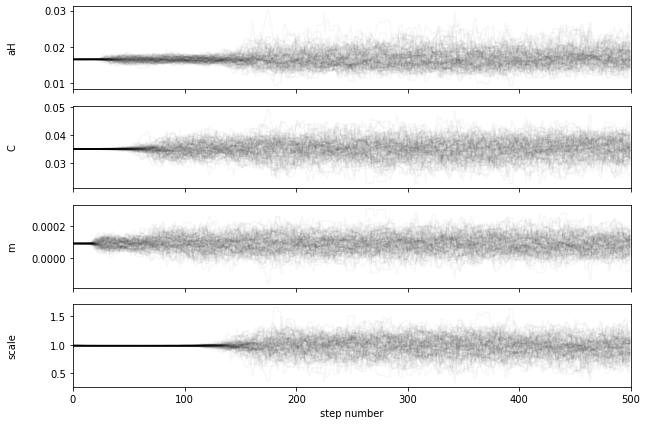

In [13]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)

print (np.shape(samples))
print (np.shape(samples[:, :, 1]))
labels = ["aH", "C", "m", "scale"]
for i in range(ndim):
    ax = axes[i]
    # when you pass ax.plot a pair, the columns represent seperate data sets
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.03)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(100, 500, 4)
(30000, 4)


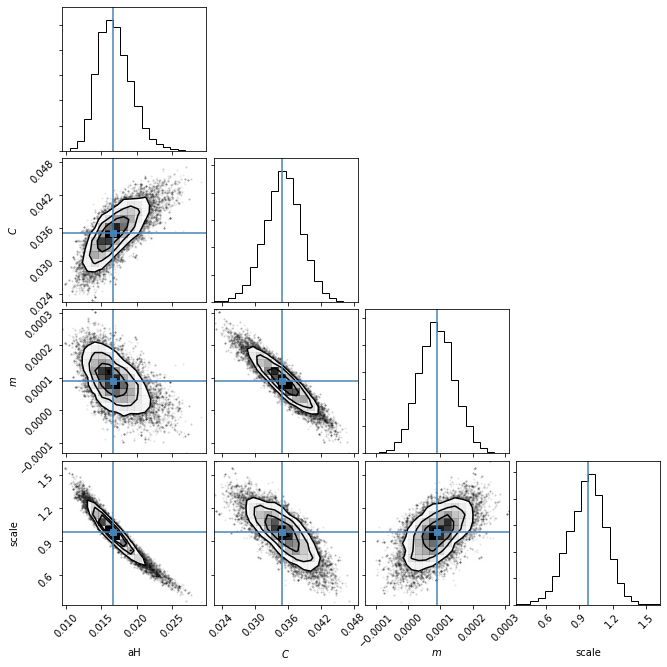

In [14]:
import corner
print(np.shape(samples))
samples = sampler.chain[:, 200:, :].reshape((-1, ndim))
print(np.shape(samples))
fig = corner.corner(samples, labels=["aH", "$C$", "$m$", "scale"],
                      truths=[aH_fit, C_fit, m_fit, scale_fit])

(30000, 4)


(0.04, 0.1)

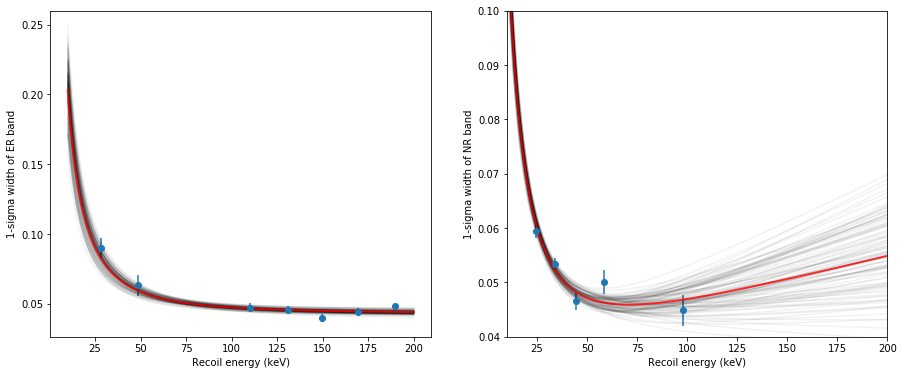

In [15]:
fig, axs = plt.subplots(1,2,figsize=(15,6))
# the ER-band fit
ax1 = axs[0]
ax2 = axs[1]

Erecoil = np.linspace(10, 200, 500)
print(np.shape(samples))
for aH, C, m, scale in samples[np.random.randint(len(samples), size=100)]:
    # GGA3 parameters from Edelweiss tables
    ion_center_0keV = 1.3
    ion_guard_0keV = 1.5
    heat_0keV = 0.4
    ion_122keV = 3.1 
    heat_122keV = 2.7
    par_dict = {'V' : scale*4.0,'eps_eV' : 3.0}
    
    sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                    par_dict, aH)
    
    sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                      par_dict, aH, C, m)
    
    ax1.plot(Erecoil, sigER_func(Erecoil), color="k", alpha=0.05)
    ax2.plot(Erecoil, sigNR_func(Erecoil), color="k", alpha=0.05)

# plot the best fit
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
par_dict = {'V' : scale_fit*4.0,'eps_eV' : 3.0}

ref_sigER_func = get_sig_gamma_func(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                par_dict, aH_fit)
    
ref_sigNR_func = get_sig_nuc_func_alt(ion_center_0keV, ion_guard_0keV, ion_122keV, heat_0keV, heat_122keV, \
                                  par_dict, aH_fit, C_fit, m_fit)
ax1.plot(Erecoil, ref_sigER_func(Erecoil), color="r", lw=2, alpha=0.8)
ax2.plot(Erecoil, ref_sigNR_func(Erecoil), color="r", lw=2, alpha=0.8)

# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")
ax2.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data")

#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
ax2.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of NR band")
    
plt.xlim(10, 200)
ax2.set_ylim(0.04, 0.1)